#### Notebook 'Tempo'

In [1]:
# Carga de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from itertools import combinations
from collections import Counter
from pyvis.network import Network
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities


In [2]:
# Crear el DataFrame 'df_aspectos' con los aspectos y las variables asociadas
data_aspectos = {
    'aspecto': ['DROGAS_Y_CORRUPCIÓN'],
    'var_1': ['per603'],
    'var_2': ['per604'],
    'var_3': ['per605'],
    'var_4': ['per104'],
    'var_5': ['per304']
}
df_aspectos = pd.DataFrame(data_aspectos)
display(df_aspectos)
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
display(df_AD.head())

,aspecto,var_1,var_2,var_3,var_4,var_5
0,DROGAS_Y_CORRUPCIÓN,per603,per604,per605,per104,per304


,Dominio,Nombre_Dominio,Variable_per,Detalle_Dominio
0,Domain_1,External Relations,per101,Foreign Special Relationships: Positive
1,Domain_1,External Relations,per102,Foreign Special Relationships: Negative
2,Domain_1,External Relations,per103,Anti-Imperialism
3,Domain_1,External Relations,per104,Military: Positive
4,Domain_1,External Relations,per105,Military: Negative


In [3]:
# Cargar datasets
df = pd.read_excel('./data/MP_Dataset_KMeans_mean.xlsx')  # Dataset principal
print("Datos cargados:")
display(df.head())


Datos cargados:


,agno,countryname,ventana_10,ventana_5,tipovoto,per101,per102,per103,per104,per105,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,1997,Albania,190,16,pervote,1.770988,0.00000,0.031388,3.046506,0.015910,...,2.021481,0.0,0.0,0.0,0.0,0.0,0.637892,0.363756,0.0,0.0
1,2001,Albania,200,17,pervote,2.392570,0.00000,0.000000,2.757403,0.026619,...,0.989546,0.0,0.0,0.0,0.0,0.0,0.897238,0.508457,0.0,0.0
2,1989,Argentina,180,14,presvote,0.000000,0.00000,4.619213,0.448618,0.828036,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,1995,Argentina,190,16,presvote,0.061642,0.02014,0.143247,0.882433,0.083005,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,1999,Argentina,190,16,presvote,0.192543,0.00000,0.582363,0.524400,0.017829,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


#### Paso 3: Funciones en pipeline de proceso

##### Filtrar y Normalizar

In [4]:
def preprocesar_periodo(df, desde, hasta):
    """
    Preprocesa el DataFrame para el período seleccionado.
    Combina registros de países con múltiples elecciones en el período y normaliza las variables.
    
    Parámetros:
    - df: DataFrame principal con datos de programas de gobierno.
    - desde: Año inicial del período.
    - hasta: Año final del período.

    Retorna:
    - df_periodo: DataFrame preprocesado con un registro por país en el período.
    """
    # Filtrar el DataFrame para el período
    df_periodo = df[(df['agno'] >= desde) & (df['agno'] <= hasta)]

    # Identificar países con más de una elección en el período
    duplicated_countries = df_periodo['countryname'].value_counts()
    duplicated_countries = duplicated_countries[duplicated_countries > 1]

    if not duplicated_countries.empty:
        #print("\nPaíses con más de una elección en el período:")
        for country in duplicated_countries.index:
            #print(f"\n{country}:")

            # Filtrar datos del país con duplicados
            country_data = df_periodo[df_periodo['countryname'] == country]

            # Imprimir los registros originales
            #print(f"Registros originales ({len(country_data)}):")
            #display(country_data)

            # Promediar las columnas `per` y conservar el primer año
            per_columns = [col for col in df_periodo.columns if col.startswith('per')]
            averaged_row = country_data[per_columns].mean().to_dict()
            averaged_row['agno'] = country_data['agno'].min()  # Primer año del período
            averaged_row['countryname'] = country

            # Imprimir los valores promedio
            #print("\nValores promediados:")
            for key, value in averaged_row.items():
                if key in per_columns:  # Solo mostrar columnas 'per'
                    print(f"{key}: {value:.4f}")

            # Eliminar los registros originales del dataframe filtrado
            df_periodo = df_periodo[df_periodo['countryname'] != country]

            # Agregar el registro promediado al dataframe
            df_periodo = pd.concat([df_periodo, pd.DataFrame([averaged_row])], ignore_index=True)

    else:
        print("\nNo hay países con más de una elección en el período.")

    # Verificar los resultados finales
    #print("\nDataframe ajustado (un registro por país en el período):")
    #display(df_periodo)

    return df_periodo


In [5]:
def filtrar_y_normalizar(df_periodo, variables):
    """
    Filtra y normaliza las columnas 'per' en un DataFrame para un período específico.
    Elimina registros con valores NaN o donde todas las columnas 'per' seleccionadas son 0.

    Parámetros:
    - df_periodo: DataFrame ya preprocesado para un período (salida de `preprocesar_periodo`).
    - variables: Lista de columnas 'per' relevantes para el aspecto en análisis.

    Retorna:
    - df_filtered: DataFrame filtrado y normalizado.
    """
    # Filtrar el DataFrame para las columnas seleccionadas
    df_filtered = df_periodo[['countryname', 'agno'] + list(variables)].copy()

    # Identificar registros con valores NaN
    registros_nan = df_filtered[df_filtered[variables].isna().any(axis=1)]
    if not registros_nan.empty:
        print("\nRegistros eliminados por contener valores NaN:")
        #display(registros_nan)

    # Eliminar registros con valores NaN
    df_filtered.dropna(inplace=True)

    # Identificar registros con todos los valores en cero
    registros_cero = df_filtered[df_filtered[variables].sum(axis=1) == 0]
    if not registros_cero.empty:
        print("\nRegistros eliminados por tener todas las variables seleccionadas en cero:")
        #display(registros_cero)

    # Eliminar registros con todos los valores en cero
    df_filtered = df_filtered[df_filtered[variables].sum(axis=1) > 0]

    # Normalizar las columnas 'per'
    columns_per = variables
    df_filtered['per_sum'] = df_filtered[columns_per].sum(axis=1)
    rows_to_normalize = df_filtered['per_sum'] != 1.0
    df_filtered.loc[rows_to_normalize, columns_per] = df_filtered.loc[rows_to_normalize, columns_per].div(
        df_filtered.loc[rows_to_normalize, 'per_sum'], axis=0
    )
    df_filtered.drop(columns=['per_sum'], inplace=True)

    # Verificar que las variables 'per' sumen 1
    assert df_filtered[columns_per].sum(axis=1).round(6).eq(1).all(), "Error: las variables 'per' no suman 1."

    return df_filtered


##### PCA y K-MEANS

In [6]:
def ejecutar_y_visualizar_pca_kmeans(df_filtered, variables, aspecto_filtro, desde, hasta):
    """
    Ejecuta PCA y K-MEANS, y visualiza los resultados en 2D y 3D con títulos personalizados.
    
    Parámetros:
    - df_filtered: DataFrame filtrado y normalizado.
    - variables: Lista de variables 'per' a incluir en el análisis.
    - aspecto_filtro: Aspecto analizado (str).
    - desde: Año inicial del período.
    - hasta: Año final del período.
    
    Retorna:
    - df_pca: DataFrame con las componentes principales y los clústeres.
    - pca: Objeto PCA ajustado.
    - kmeans: Objeto K-MEANS ajustado.
    """
    # Paso 1: Ejecutar PCA
    numeric_data = df_filtered[variables]
    pca = PCA(n_components=min(len(variables), 3))  # Usar hasta 3 componentes principales
    pca_components = pca.fit_transform(numeric_data)
    
    # Crear DataFrame con las componentes principales
    df_pca = pd.DataFrame(
        pca_components, 
        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
        index=df_filtered.index
    )
    df_pca = pd.concat([df_filtered[['countryname', 'agno']], df_pca], axis=1)
    
    # Paso 2: Aplicar K-MEANS
    optimal_k = 3  # Por defecto usamos 3 clústeres (puedes ajustar o calcular dinámicamente)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df_pca['cluster'] = kmeans.fit_predict(df_pca[[f'PC{i+1}' for i in range(pca.n_components_)]])
    
    # Paso 3: Visualizar clústeres en 2D
    # plt.figure(figsize=(12, 6))
    # for cluster in range(optimal_k):
    #     cluster_data = df_pca[df_pca['cluster'] == cluster]
    #     plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.7)
    # plt.title(f"Clústeres en 2D (PCA)\nAspecto: {aspecto_filtro} | Período: {desde}-{hasta}")
    # plt.xlabel('PC1')
    # plt.ylabel('PC2')
    # plt.legend()
    # plt.grid(alpha=0.3)
    # plt.tight_layout()
    # plt.show()
    
    return df_pca, pca, kmeans


##### Matriz de coincidencias

In [7]:
def construir_matriz_coincidencias(resultados_temporales):
    coincidencias = Counter()
    for clusters in resultados_temporales.values():
        for cluster in clusters.values():
            for pair in combinations(sorted(cluster), 2):
                coincidencias[pair] += 1

    # Convertir a matriz
    paises = sorted(set([p for pair in coincidencias.keys() for p in pair]))
    coincidence_matrix = pd.DataFrame(0, index=paises, columns=paises)

    for (p1, p2), count in coincidencias.items():
        coincidence_matrix.loc[p1, p2] = count
        coincidence_matrix.loc[p2, p1] = count

    return coincidence_matrix


#### Grafo de Trayectorias temporales

#### Gráfico de coincidencias (con un cierto mínimo)

In [8]:
# LOUVAIN
from pyvis.network import Network
import networkx as nx
from community import community_louvain  # Librería para Louvain

def grafo_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10):
    """
    Crea un grafo interactivo mejorado a partir de la matriz de coincidencias,
    filtrando conexiones con menos de `min_coincidencias` coincidencias.
    
    Parámetros:
    - coincidence_matrix: Matriz de coincidencias entre países.
    - min_coincidencias: Número mínimo de coincidencias para mostrar una conexión.
    """
    # Crear el grafo de NetworkX
    G = nx.Graph()
    for i, row in coincidence_matrix.iterrows():
        for j, value in row.items():
            if value >= min_coincidencias:  # Filtrar por número mínimo de coincidencias
                G.add_edge(i, j, weight=value)  # Añadir peso correctamente

    # Detectar comunidades usando el algoritmo Louvain
    partition = community_louvain.best_partition(G)
    communities = {}
    for node, community in partition.items():
        communities.setdefault(community, []).append(node)

    # Crear un grafo interactivo con PyVis
    net = Network(notebook=True, height="750px", width="100%", cdn_resources="remote")
    net.from_nx(G)

    # Configurar físicas para deshabilitarlas
    net.set_options("""
    var options = {
      "physics": {
        "enabled": false
      }
    }
    """)

    # Ajustar nodos y aristas
    for node in net.nodes:
        # Color del nodo según la comunidad detectada
        community = partition[node["id"]]
        node["color"] = f"hsl({community * 360 / len(communities)}, 70%, 70%)"
        
        # Tamaño del nodo según el grado
        node["value"] = len(list(G.neighbors(node["id"])))

    for edge in net.edges:
        # Grosor de las aristas según el peso
        from_node = edge["from"]
        to_node = edge["to"]
        if G.has_edge(from_node, to_node):
            edge["width"] = G[from_node][to_node].get("weight", 1)  # Usar 1 como valor por defecto

    # Calcular métricas de centralidad
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    # Mostrar las métricas en la terminal
    print("\nCentralidad de Grado (Top 5):")
    for node, centrality in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"{node}: {centrality:.4f}")

    print("\nCentralidad de Betweenness (Top 5):")
    for node, centrality in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"{node}: {centrality:.4f}")

    # Guardar el grafo en un archivo HTML
    output_file = "LOUVAIN_grafo_coincidencias_filtrado.html"
    net.show(output_file)
    print(f"Grafo guardado como '{output_file}'. Ábrelo para visualizar.")


In [9]:
# # GREEDY MODULARITY COMMUNITIES
# from pyvis.network import Network
# import networkx as nx
# from networkx.algorithms.community import greedy_modularity_communities

# def grafo_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10):
#     """
#     Crea un grafo interactivo mejorado a partir de la matriz de coincidencias,
#     filtrando conexiones con menos de `min_coincidencias` coincidencias.
    
#     Parámetros:
#     - coincidence_matrix: Matriz de coincidencias entre países.
#     - min_coincidencias: Número mínimo de coincidencias para mostrar una conexión.
#     """
#     # Crear el grafo de NetworkX
#     G = nx.Graph()
#     for i, row in coincidence_matrix.iterrows():
#         for j, value in row.items():
#             if value >= min_coincidencias:  # Filtrar por número mínimo de coincidencias
#                 G.add_edge(i, j, weight=value)  # Añadir peso correctamente

#     # Detectar comunidades usando modularidad
#     communities = list(greedy_modularity_communities(G))
#     community_map = {}
#     for community_index, community_nodes in enumerate(communities):
#         for node in community_nodes:
#             community_map[node] = community_index

#     # Crear un grafo interactivo con PyVis
#     net = Network(notebook=True, height="750px", width="100%", cdn_resources="remote")
#     net.from_nx(G)

#     # Configurar físicas para deshabilitarlas
#     net.set_options("""
#     var options = {
#       "physics": {
#         "enabled": false
#       }
#     }
#     """)

#     # Ajustar nodos y aristas
#     for node in net.nodes:
#         # Color del nodo según la comunidad
#         community = community_map[node["id"]]
#         node["color"] = f"hsl({community * 360 / len(communities)}, 70%, 70%)"
        
#         # Tamaño del nodo según el grado
#         node["value"] = len(list(G.neighbors(node["id"])))

#     for edge in net.edges:
#         # Grosor de las aristas según el peso
#         from_node = edge["from"]
#         to_node = edge["to"]
#         if G.has_edge(from_node, to_node):
#             edge["width"] = G[from_node][to_node].get("weight", 1)  # Usar 1 como valor por defecto

#     # Guardar el grafo en un archivo HTML
#     output_file = "GREEDY_grafo_coincidencias_filtrado.html"
#     net.show(output_file)
#     print(f"Grafo guardado como '{output_file}'. Ábrelo para visualizar.")
    
#     # Agregar la leyenda directamente al archivo HTML
#     legend_html = f"""
#     <div style="position: absolute; top: 10px; right: 10px; background-color: white; border: 1px solid black; padding: 10px; z-index: 1000;">
#         <strong>GRAFO DE COINCIDENCIAS</strong>
#         <strong>Leyenda:</strong>
#         <ul style="list-style-type: none; padding-left: 0;">
#             <li><strong>Nodos:</strong> Países</li>
#             <li><strong>Tamaño:</strong> Grado del nodo (cantidad de conexiones)</li>
#             <li><strong>Color:</strong> Comunidad detectada</li>
#             <li><strong>Aristas:</strong> Coincidencias entre países</li>
#             <li><strong>Grosor:</strong> Peso de la conexión (coincidencias >= {min_coincidencias})</li>
#         </ul>
#     </div>
#     """
#     with open(output_file, "r", encoding="utf-8") as file:
#         html_content = file.read()
    
#     # Insertar la leyenda antes del cierre del body
#     html_content = html_content.replace("</body>", legend_html + "\n</body>")
    
#     with open(output_file, "w", encoding="utf-8") as file:
#         file.write(html_content)

#     print("Leyenda añadida al archivo HTML.")


#### Heatmap de coincidencias (con un cierto mínimo)

In [10]:
def heatmap_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10, cmap="coolwarm"):
    """
    Genera un heatmap mostrando solo los países que tienen coincidencias >= min_coincidencias,
    con las celdas que cumplen mostrando el número real de coincidencias y las que no cumplen en blanco.
    
    Parámetros:
    - coincidence_matrix: Matriz de coincidencias entre países.
    - min_coincidencias: Número mínimo de coincidencias para considerar un enlace.
    - cmap: Paleta de colores para el heatmap.
    """
    # Crear una copia de la matriz para no modificar el original
    filtered_matrix = coincidence_matrix.copy()
    
    # Filtrar países que cumplen el umbral en filas o columnas
    relevant_countries = (filtered_matrix >= min_coincidencias).sum(axis=1) > 0
    filtered_matrix = filtered_matrix.loc[relevant_countries, relevant_countries]
    
    # Crear una máscara para ocultar valores por debajo del umbral
    mask = filtered_matrix < min_coincidencias
    
    # Verificar si quedan datos para graficar
    if filtered_matrix.empty:
        print(f"No hay países con coincidencias >= {min_coincidencias}.")
        return
    
    # Crear el heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        filtered_matrix,
        annot=filtered_matrix.where(~mask).round(0),  # Mostrar valores enteros redondeados
        fmt="g",  # Usar formato general (float/int)
        cmap=cmap,
        linewidths=0.5,  # Añadir líneas de la grilla
        linecolor="gray",
        cbar_kws={"label": "Número de Coincidencias"},
        mask=mask  # Aplicar la máscara
    )
    plt.title(f"Heatmap de Coincidencias Filtrado (≥ {min_coincidencias})\nDrogas y Corrupción (1949 a 2022)", fontsize=14)
    plt.xlabel("País")
    plt.ylabel("País")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()


#### Ejecución para un período

In [ ]:
resultados_temporales

#### Ejecución para Múltiples Períodos


Procesando período: 1949-1951
per101: 2.1474
per102: 0.0000
per103: 0.0000
per104: 4.9943
per105: 0.6320
per106: 0.8173
per107: 1.6590
per108: 0.0000
per109: 0.0614
per110: 0.0000
per201: 1.7767
per202: 0.9856
per203: 2.0346
per204: 0.0000
per301: 0.6445
per302: 0.1459
per303: 3.9862
per304: 0.0000
per305: 5.0049
per401: 4.0828
per402: 1.2052
per403: 1.9520
per404: 3.2042
per405: 0.0000
per406: 0.3774
per407: 0.0829
per408: 7.3901
per409: 0.0000
per410: 2.9427
per411: 2.3328
per412: 0.0000
per413: 0.1911
per414: 6.9560
per415: 0.0000
per416: 0.0000
per501: 0.0000
per502: 1.9677
per503: 0.0717
per504: 6.2054
per505: 0.4563
per506: 0.4265
per507: 0.0000
per601: 0.0000
per602: 0.0000
per603: 1.5246
per604: 0.0000
per605: 0.1459
per606: 6.4896
per607: 0.0000
per608: 0.0000
per701: 10.0045
per702: 0.9515
per703: 9.5408
per704: 0.5288
per705: 0.0000
per706: 3.8357
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)




No hay países con más de una elección en el período.

Registros eliminados por tener todas las variables seleccionadas en cero:

Procesando período: 1955-1957

No hay países con más de una elección en el período.

Registros eliminados por tener todas las variables seleccionadas en cero:

Procesando período: 1958-1960
per101: 0.0000
per102: 0.1926
per103: 0.0000
per104: 0.5380
per105: 0.5684
per106: 1.9586
per107: 1.0020
per108: 0.3747
per109: 0.1196
per110: 0.0000
per201: 1.3564
per202: 0.4778
per203: 0.0817
per204: 0.0409
per301: 2.4830
per302: 0.0000
per303: 0.8103
per304: 0.0000
per305: 0.0000
per401: 2.8665
per402: 5.3536
per403: 1.3461
per404: 0.1189
per405: 0.0000
per406: 0.5214
per407: 0.2334
per408: 1.2524
per409: 0.4382
per410: 1.0118
per411: 1.7636
per412: 0.3731
per413: 0.0269
per414: 9.4882
per415: 0.0000
per416: 0.0000
per501: 0.0320
per502: 0.5464
per503: 2.2538
per504: 21.3379
per505: 1.9741
per506: 6.2660
per507: 0.1464
per601: 0.0000
per602: 0.0000
per603: 1.7193
per

/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/


Procesando período: 1964-1966
per101: 1.4395
per102: 0.3878
per103: 0.5821
per104: 1.3394
per105: 0.7189
per106: 2.0225
per107: 4.4525
per108: 1.3977
per109: 0.4939
per110: 0.0976
per201: 1.3969
per202: 1.0905
per203: 0.5181
per204: 0.1464
per301: 2.4309
per302: 0.3202
per303: 2.5883
per304: 0.1423
per305: 1.0576
per401: 1.6040
per402: 1.2262
per403: 1.1416
per404: 1.2122
per405: 0.0000
per406: 0.3319
per407: 0.3792
per408: 3.1818
per409: 0.1415
per410: 1.5568
per411: 4.1373
per412: 0.8207
per413: 0.8252
per414: 2.1402
per415: 0.0000
per416: 0.0000
per501: 1.9250
per502: 2.2381
per503: 3.5409
per504: 7.6122
per505: 0.5126
per506: 3.4874
per507: 0.3290
per601: 1.1895
per602: 0.1952
per603: 0.2377
per604: 0.0000
per605: 1.5324
per606: 1.1535
per607: 0.0425
per608: 0.0000
per701: 1.2695
per702: 0.7556
per703: 2.2299
per704: 0.9941
per705: 0.4990
per706: 1.9834
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
p

/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/


Procesando período: 1976-1978
per101: 0.2666
per102: 0.0000
per103: 1.0093
per104: 0.3351
per105: 0.9449
per106: 0.1423
per107: 0.7398
per108: 3.9329
per109: 0.6788
per110: 0.3174
per201: 2.9386
per202: 5.0208
per203: 0.4787
per204: 0.3870
per301: 4.8880
per302: 0.0215
per303: 3.1627
per304: 0.3845
per305: 0.8823
per401: 3.1863
per402: 2.4303
per403: 2.0521
per404: 1.6454
per405: 0.0000
per406: 0.0429
per407: 0.0730
per408: 4.8469
per409: 0.3776
per410: 0.6337
per411: 4.6877
per412: 0.8864
per413: 0.6433
per414: 1.8161
per415: 0.0000
per416: 0.0043
per501: 3.2892
per502: 5.5790
per503: 4.1566
per504: 3.8341
per505: 0.6107
per506: 1.5562
per507: 0.0316
per601: 0.3937
per602: 0.2357
per603: 1.0490
per604: 0.2447
per605: 0.2870
per606: 0.9030
per607: 1.4855
per608: 0.4589
per701: 0.9552
per702: 0.0000
per703: 1.4542
per704: 3.4094
per705: 2.1842
per706: 10.8459
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/


Procesando período: 1988-1990
per101: 1.4629
per102: 0.3079
per103: 0.0000
per104: 6.4252
per105: 1.1780
per106: 0.3020
per107: 2.1517
per108: 3.9203
per109: 0.8976
per110: 0.8554
per201: 0.8614
per202: 2.3793
per203: 0.0383
per204: 0.0159
per301: 1.3570
per302: 0.1967
per303: 1.7576
per304: 0.1254
per305: 0.5727
per401: 1.4683
per402: 4.3018
per403: 0.6458
per404: 0.3127
per405: 0.9686
per406: 0.0000
per407: 0.0658
per408: 3.3659
per409: 0.0195
per410: 0.9071
per411: 2.1874
per412: 1.0050
per413: 0.0268
per414: 0.5495
per415: 0.0195
per416: 0.1979
per501: 4.9930
per502: 0.4180
per503: 3.3209
per504: 5.4938
per505: 1.0866
per506: 3.4957
per507: 0.0435
per601: 0.1557
per602: 0.0537
per603: 1.6161
per604: 0.0000
per605: 2.0639
per606: 2.1533
per607: 0.1162
per608: 0.1062
per701: 7.6167
per702: 0.2547
per703: 0.6099
per704: 0.2217
per705: 0.0000
per706: 4.6578
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
p

/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/


Procesando período: 2000-2002
per101: 0.8492
per102: 0.0000
per103: 0.0076
per104: 0.9656
per105: 0.0853
per106: 0.1579
per107: 1.3301
per108: 1.0279
per109: 0.5067
per110: 0.0000
per201: 5.0716
per202: 3.7228
per203: 2.6578
per204: 2.7273
per301: 1.5453
per302: 0.6451
per303: 1.9521
per304: 0.8524
per305: 1.3570
per401: 2.8366
per402: 1.4407
per403: 0.1863
per404: 0.0094
per405: 0.2696
per406: 0.0516
per407: 0.0986
per408: 3.3009
per409: 0.0762
per410: 3.9586
per411: 6.4241
per412: 0.0000
per413: 0.0305
per414: 1.9761
per415: 0.0000
per416: 0.1855
per501: 1.3039
per502: 2.6257
per503: 1.4321
per504: 9.2298
per505: 0.2666
per506: 4.3697
per507: 0.0000
per601: 7.0405
per602: 0.5697
per603: 0.9435
per604: 0.1856
per605: 0.7867
per606: 1.1897
per607: 2.8414
per608: 0.0800
per701: 2.0322
per702: 0.0000
per703: 4.2684
per704: 1.2777
per705: 0.0000
per706: 2.3021
per1011: 0.0266
per1012: 0.0980
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.1219
per1021: 0.0000
per1022: 0.0000
p

/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/


Procesando período: 2012-2014
per101: 0.3719
per102: 0.9187
per103: 0.2285
per104: 5.5972
per105: 0.1412
per106: 0.7126
per107: 1.0560
per108: 3.0149
per109: 0.0000
per110: 0.1412
per201: 3.7087
per202: 8.9821
per203: 0.1469
per204: 0.4016
per301: 3.0647
per302: 0.0000
per303: 0.4205
per304: 9.0021
per305: 5.7956
per401: 1.5055
per402: 2.2386
per403: 3.0440
per404: 0.5251
per405: 0.3804
per406: 0.8577
per407: 0.3401
per408: 0.0683
per409: 0.0000
per410: 1.7360
per411: 5.7600
per412: 1.0186
per413: 1.6744
per414: 0.5891
per415: 0.2188
per416: 0.5661
per501: 0.7555
per502: 0.7043
per503: 4.3277
per504: 6.0329
per505: 0.0729
per506: 2.1292
per507: 0.0000
per601: 6.0397
per602: 0.0729
per603: 0.2914
per604: 0.0000
per605: 2.1891
per606: 3.9038
per607: 1.4886
per608: 0.0000
per701: 3.8338
per702: 0.0000
per703: 2.2790
per704: 0.7716
per705: 0.0000
per706: 0.8109
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
p

/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Centralidad de Grado (Top 5):
New Zealand: 0.4706
Denmark: 0.4118
Sweden: 0.3529
Iceland: 0.2941
Australia: 0.2353

Centralidad de Betweenness (Top 5):
New Zealand: 0.3542
Denmark: 0.2819
Sweden: 0.2304
Iceland: 0.2004
Germany: 0.1746
LOUVAIN_grafo_coincidencias_filtrado.html
Grafo guardado como 'LOUVAIN_grafo_coincidencias_filtrado.html'. Ábrelo para visualizar.


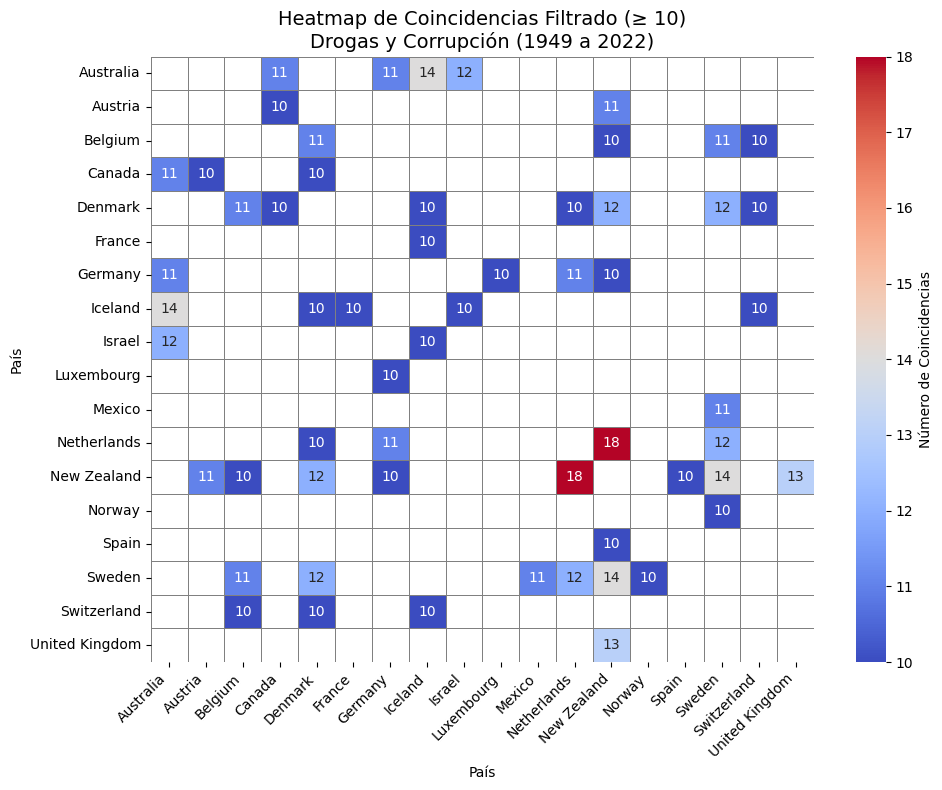

In [11]:
# Definir períodos múltiples para el análisis
periodos = [(1949, 1951),(1952, 1954),(1955, 1957),(1958, 1960),(1961, 1963),(1964, 1966), (1967, 1969), (1970, 1972), (1973, 1975), (1976, 1978), (1979, 1981), (1982, 1984), (1985, 1987), (1988, 1990), (1991, 1993), (1994, 1996), (1997, 1999), (2000, 2002), (2003, 2005), (2006, 2008), (2009, 2011), (2012, 2014), (2015, 2017), (2018, 2020), (2021, 2022)]
aspecto_filtro = 'DROGAS_Y_CORRUPCIÓN'
variables = df_aspectos[df_aspectos['aspecto'] == aspecto_filtro][['var_1', 'var_2', 'var_3', 'var_4', 'var_5']].dropna().values.flatten()

# Diccionario para almacenar resultados por período
resultados_temporales = {}

for desde, hasta in periodos:
    print(f"\nProcesando período: {desde}-{hasta}")
    
    # Preprocesar y normalizar datos
    df_periodo = preprocesar_periodo(df, desde, hasta)
    df_filtered = filtrar_y_normalizar(df_periodo, variables)
    
    # Ejecutar PCA y K-MEANS
    df_pca, pca, kmeans = ejecutar_y_visualizar_pca_kmeans(df_filtered, variables, aspecto_filtro, desde, hasta)
    
    # Almacenar los países en cada clúster
    clusters = {}
    for cluster in df_pca['cluster'].unique():
        clusters[cluster] = df_pca[df_pca['cluster'] == cluster]['countryname'].unique()
    resultados_temporales[f"{desde}-{hasta}"] = clusters

# Construir y visualizar la matriz de coincidencias
coincidence_matrix = construir_matriz_coincidencias(resultados_temporales)
#grafo_coincidencias(coincidence_matrix)

#paises_seleccionados = ["Armenia", "Finland", "United States", "Australia", "Georgia"]
#paises_seleccionados = ["Armenia", "United States"]
#graficar_trayectorias_seleccion(resultados_temporales, paises_seleccionados)
grafo_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10)

# Ejecutar heatmap filtrando según un umbral
heatmap_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10, cmap="coolwarm")

In [12]:
coincidence_matrix

,Albania,Argentina,Armenia,Australia,Austria,Azerbaijan,Belarus,Belgium,Bolivia,Bosnia-Herzegovina,...,South Korea,Spain,Sri Lanka,Sweden,Switzerland,Turkey,Ukraine,United Kingdom,United States,Uruguay
Albania,0,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,2,2,0,0,0
Argentina,1,0,1,0,2,0,0,1,2,2,...,2,1,0,1,0,4,3,0,0,0
Armenia,1,1,0,4,0,0,1,1,0,1,...,2,3,0,0,0,2,2,1,5,0
Australia,0,0,4,0,8,0,1,5,0,2,...,5,4,0,3,7,6,1,9,9,0
Austria,0,2,0,8,0,1,0,3,1,2,...,2,4,0,6,5,7,1,8,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Turkey,2,4,2,6,7,0,0,3,1,1,...,0,1,0,4,2,0,2,2,6,0
Ukraine,2,3,2,1,1,0,0,0,1,2,...,2,0,0,0,0,2,0,0,1,0
United Kingdom,0,0,1,9,8,1,0,5,0,0,...,2,8,0,6,5,2,0,0,8,0
United States,0,0,5,9,6,2,0,4,0,0,...,2,6,0,5,3,6,1,8,0,0


### <<<<<<<<<<<< NO USAR DESDE >>>>>>>>>>>>

In [13]:
def generar_dataframe_por_periodo(periodo, resultados_temporales):
    """
    Genera un DataFrame para un período específico con columnas 'periodo', 'Cluster_1', 'Cluster_2', 'Cluster_3'.
    Cada columna de clúster contiene los países listados verticalmente.
    
    Parámetros:
    - periodo: Periodo en formato 'YYYY-YYYY' (ejemplo: '1970-1972').
    - resultados_temporales: Diccionario con los resultados de clústeres por período.
    
    Retorna:
    - DataFrame con las columnas 'periodo', 'Cluster_1', 'Cluster_2', 'Cluster_3'.
    """
    if periodo not in resultados_temporales:
        print(f"El período {periodo} no está en los resultados disponibles.")
        return pd.DataFrame()  # Devuelve un DataFrame vacío

    # Extraer los clústeres del período seleccionado
    clusters = resultados_temporales[periodo]

    # Obtener países en cada clúster y asegurarse de que los clusters tengan un formato uniforme
    cluster_data = {}
    max_paises = 0
    for cluster_id in range(1, 4):  # Asumimos hasta 3 clusters
        cluster_key = cluster_id - 1  # Ajustar al índice del diccionario
        paises = sorted(clusters.get(cluster_key, []))  # Obtener países en el clúster o lista vacía
        cluster_data[f"Cluster_{cluster_id}"] = paises
        max_paises = max(max_paises, len(paises))

    # Crear un DataFrame con las columnas del clúster
    df = pd.DataFrame({
        "periodo": [periodo] * max_paises,  # Repetir el período
        "Cluster_1": cluster_data.get("Cluster_1", []) + [None] * (max_paises - len(cluster_data.get("Cluster_1", []))),
        "Cluster_2": cluster_data.get("Cluster_2", []) + [None] * (max_paises - len(cluster_data.get("Cluster_2", []))),
        "Cluster_3": cluster_data.get("Cluster_3", []) + [None] * (max_paises - len(cluster_data.get("Cluster_3", []))),
    })

    return df

# Ejemplo de uso:
# Cambia '2019-2022' por el período que desees analizar
periodo_seleccionado = '2019-2022'
df_periodo = generar_dataframe_por_periodo(periodo_seleccionado, resultados_temporales)

# Mostrar el DataFrame
print(f"Clústeres para el período {periodo_seleccionado}:")
display(df_periodo)


El período 2019-2022 no está en los resultados disponibles.
Clústeres para el período 2019-2022:


""


In [14]:
dfs_por_periodo = []
for periodo in resultados_temporales.keys():
    df = generar_dataframe_por_periodo(periodo, resultados_temporales)
    dfs_por_periodo.append(df)

# Combinar todos los DataFrames en uno grande si lo necesitas
df_combinado = pd.concat(dfs_por_periodo, ignore_index=True)


In [15]:
display(df_combinado)

,periodo,Cluster_1,Cluster_2,Cluster_3
0,1949-1951,Austria,Finland,Australia
1,1949-1951,Canada,Germany,Belgium
2,1949-1951,Ireland,Luxembourg,Denmark
3,1949-1951,Mexico,Norway,France
4,1949-1951,Northern Ireland,Turkey,Iceland
...,...,...,...,...
322,2018-2020,None,None,United Kingdom
323,2021-2022,Armenia,Chile,Brazil
324,2021-2022,Australia,Germany,None
325,2021-2022,Iceland,Netherlands,None


In [16]:
# Define the minimum coincidences threshold
min_coincidencias = 10

# Initialize a dictionary to count the number of significant links for each country
significant_links = {}

# Iterate over the rows of the coincidence matrix
for country, row in coincidence_matrix.iterrows():
    # Count the number of connections exceeding the threshold
    count = (row >= min_coincidencias).sum()
    significant_links[country] = count

# Create a DataFrame from the significant links
significant_links_df = pd.DataFrame(
    list(significant_links.items()),
    columns=["Country", "Number of Significant Links"]
).sort_values(by="Number of Significant Links", ascending=False)

# Display the results in a user-friendly table
#import ace_tools as tools; tools.display_dataframe_to_user(name="Significant Links by Country", dataframe=significant_links_df)

# Print for reference
print(f"Countries with significant links (>= {min_coincidencias} coincidences):")
display(significant_links_df)


Countries with significant links (>= 10 coincidences):


,Country,Number of Significant Links
42,New Zealand,8
19,Denmark,7
59,Sweden,6
29,Iceland,5
26,Germany,4
...,...,...
30,Ireland,0
32,Italy,0
1,Argentina,0
34,Latvia,0


In [17]:
# Define the minimum coincidences threshold
min_coincidencias = 10

# Initialize a dictionary to store the sum of significant links for each country
significant_sums = {}

# Iterate over the rows of the coincidence matrix
for country, row in coincidence_matrix.iterrows():
    # Sum the values of connections exceeding the threshold
    total_sum = row[row >= min_coincidencias].sum()
    significant_sums[country] = total_sum

# Create a DataFrame from the significant sums
significant_sums_df = pd.DataFrame(
    list(significant_sums.items()),
    columns=["Country", "Sum of Significant Links"]
).sort_values(by="Sum of Significant Links", ascending=False)

# Display the results in a user-friendly table

# Print for reference
print(f"Countries with significant link sums (>= {min_coincidencias} coincidences):")
significant_sums_df


Countries with significant link sums (>= 10 coincidences):


,Country,Sum of Significant Links
42,New Zealand,98
19,Denmark,75
59,Sweden,70
29,Iceland,54
41,Netherlands,51
...,...,...
30,Ireland,0
32,Italy,0
1,Argentina,0
34,Latvia,0


### <<<<<<<<<<<< NO USAR HASTA >>>>>>>>>>>>

#### Análisis de la modularidad de la partición en comunidades según Greedy y según Louvain
* La modularidad es una métrica que mide la calidad de una partición en comunidades en un grafo. Una modularidad más alta indica una mejor partición, donde hay más enlaces dentro de las comunidades que los esperados por azar.
* Calcularemos la modularidad en NetworkX utilizando la función modularity() y las particiones generadas por Greedy y Louvain.

In [18]:
# Cálculo de modularidad usando Louvain y Greedy
from pyvis.network import Network
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from community import community_louvain

def grafo_coincidencias_filtrado_y_modularidad(coincidence_matrix, min_coincidencias=10):
    """
    Crea un grafo interactivo a partir de la matriz de coincidencias,
    calcula las modularidades y muestra las comunidades detectadas.
    
    Parámetros:
    - coincidence_matrix: Matriz de coincidencias entre países.
    - min_coincidencias: Número mínimo de coincidencias para mostrar una conexión.
    """
    # Crear el grafo de NetworkX
    G = nx.Graph()
    for i, row in coincidence_matrix.iterrows():
        for j, value in row.items():
            if value >= min_coincidencias:  # Filtrar por número mínimo de coincidencias
                G.add_edge(i, j, weight=value)

    # Calcular comunidades y modularidad
    calcular_modularidad_y_etiquetar(G)

    # Crear un grafo interactivo con PyVis
    net = Network(notebook=True, height="750px", width="100%", cdn_resources="remote")
    net.from_nx(G)

    # Configurar físicas para deshabilitarlas
    net.set_options("""
    var options = {
      "physics": {
        "enabled": false
      }
    }
    """)

    # Ajustar nodos y aristas
    for node in net.nodes:
        # Color del nodo según la comunidad Louvain
        louvain_community = G.nodes[node["id"]].get("Louvain_Community", "Unassigned")
        community_color = hash(louvain_community) % 360  # Color basado en hash
        node["color"] = f"hsl({community_color}, 70%, 70%)"
        
        # Tamaño del nodo según el grado
        node["value"] = len(list(G.neighbors(node["id"])))

    for edge in net.edges:
        # Grosor de las aristas según el peso
        from_node = edge["from"]
        to_node = edge["to"]
        if G.has_edge(from_node, to_node):
            edge["width"] = G[from_node][to_node].get("weight", 1)  # Usar 1 como valor por defecto

    # Guardar el grafo en un archivo HTML
    output_file = "grafo_coincidencias_filtrado.html"
    net.show(output_file)
    print(f"Grafo guardado como '{output_file}'. Ábrelo para visualizar.")
    
    # Agregar la leyenda directamente al archivo HTML
    legend_html = f"""
    <div style="position: absolute; top: 10px; right: 10px; background-color: white; border: 1px solid black; padding: 10px; z-index: 1000;">
        <strong>GRAFO DE COINCIDENCIAS</strong>
        <strong>Leyenda:</strong>
        <ul style="list-style-type: none; padding-left: 0;">
            <li><strong>Nodos:</strong> Países</li>
            <li><strong>Tamaño:</strong> Grado del nodo (cantidad de conexiones)</li>
            <li><strong>Color:</strong> Comunidad detectada</li>
            <li><strong>Aristas:</strong> Coincidencias entre países</li>
            <li><strong>Grosor:</strong> Peso de la conexión (coincidencias >= {min_coincidencias})</li>
        </ul>
    </div>
    """
    with open(output_file, "r", encoding="utf-8") as file:
        html_content = file.read()
    
    # Insertar la leyenda antes del cierre del body
    html_content = html_content.replace("</body>", legend_html + "\n</body>")
    
    with open(output_file, "w", encoding="utf-8") as file:
        file.write(html_content)

    print("Leyenda añadida al archivo HTML.")

def calcular_modularidad_y_etiquetar(G):
    """
    Calcula las comunidades utilizando Greedy y Louvain, 
    asigna nombres de comunidad como atributos y muestra las modularidades.
    
    Parámetros:
    - G: Grafo generado a partir de la matriz de coincidencias.
    """
    # Greedy Modularity Communities
    greedy_communities = list(greedy_modularity_communities(G))
    greedy_modularity = nx.algorithms.community.modularity(G, greedy_communities)

    # Crear un mapeo nodo -> comunidad para Greedy
    greedy_map = {}
    for i, community in enumerate(greedy_communities):
        for node in community:
            greedy_map[node] = f"Greedy_{i + 1}"  # Etiqueta: Greedy_1, Greedy_2, etc.

    # Louvain Modularity Communities
    louvain_partition = community_louvain.best_partition(G)
    louvain_modularity = community_louvain.modularity(louvain_partition, G)

    # Crear un mapeo nodo -> comunidad para Louvain
    louvain_map = {node: f"Louvain_{comm}" for node, comm in louvain_partition.items()}

    # Mostrar modularidades
    print(f"Modularidad (Greedy): {greedy_modularity:.4f}")
    print(f"Modularidad (Louvain): {louvain_modularity:.4f}")

    # Asignar nombres de comunidad a los nodos como atributos
    nx.set_node_attributes(G, greedy_map, "Greedy_Community")
    nx.set_node_attributes(G, louvain_map, "Louvain_Community")

    # Mostrar las comunidades generadas
    print("\nComunidades detectadas con Greedy:")
    for i, community in enumerate(greedy_communities, start=1):
        print(f"Greedy_{i}: {sorted(community)}")

    print("\nComunidades detectadas con Louvain:")
    louvain_communities = {}
    for node, comm in louvain_partition.items():
        louvain_communities.setdefault(comm, []).append(node)
    for i, (comm, nodes) in enumerate(sorted(louvain_communities.items()), start=1):
        print(f"Louvain_{comm}: {sorted(nodes)}")

# Ejecutar el análisis con un umbral de coincidencias
grafo_coincidencias_filtrado_y_modularidad(coincidence_matrix, min_coincidencias=10)


Modularidad (Greedy): 0.3230
Modularidad (Louvain): 0.3237

Comunidades detectadas con Greedy:
Greedy_1: ['Belgium', 'Denmark', 'Mexico', 'Norway', 'Sweden', 'Switzerland']
Greedy_2: ['Germany', 'Luxembourg', 'Netherlands', 'New Zealand', 'Spain', 'United Kingdom']
Greedy_3: ['Australia', 'France', 'Iceland', 'Israel']
Greedy_4: ['Austria', 'Canada']

Comunidades detectadas con Louvain:
Louvain_0: ['Belgium', 'Denmark', 'Mexico', 'Norway', 'Sweden', 'Switzerland']
Louvain_1: ['Australia', 'Austria', 'Canada', 'France', 'Iceland', 'Israel']
Louvain_2: ['Germany', 'Luxembourg', 'Netherlands', 'New Zealand', 'Spain', 'United Kingdom']
grafo_coincidencias_filtrado.html


Grafo guardado como 'grafo_coincidencias_filtrado.html'. Ábrelo para visualizar.
Leyenda añadida al archivo HTML.


#### Final?

In [19]:
from pyvis.network import Network
import networkx as nx
from networkx.algorithms.community import louvain_communities
import pandas as pd
import matplotlib.pyplot as plt

def grafo_clusters_final(coincidence_matrix, min_coincidencias=10):
    """
    Crea el grafo final de clusters basado en la matriz de coincidencias,
    filtrando por un número mínimo de coincidencias y calculando métricas de centralidad.
    """
    # Crear el grafo de NetworkX
    G = nx.Graph()
    for i, row in coincidence_matrix.iterrows():
        for j, value in row.items():
            if value >= min_coincidencias:  # Filtrar por número mínimo de coincidencias
                G.add_edge(i, j, weight=value)  # Añadir peso correctamente

    # Verificar si hay pesos asignados
    if not nx.get_edge_attributes(G, 'weight'):
        print("No se encontraron aristas con 'weight'. Verifica la matriz de coincidencias.")
        return

    # Detectar comunidades con Louvain
    communities = louvain_communities(G, weight='weight', seed=42)
    community_map = {}
    for community_index, community_nodes in enumerate(communities):
        for node in community_nodes:
            community_map[node] = community_index

    # Listar países en cada comunidad horizontalmente
    print("\nRED DE COINCIDENCIAS\n***** Países en cada comunidad (Louvain) *****")
    community_list = []
    for community_index, community_nodes in enumerate(communities):
        countries = ", ".join(sorted(community_nodes))
        print(f"Comunidad {community_index}: [{countries}]")
        community_list.append({"Comunidad": community_index, "Países": f"[{countries}]"})

    # Crear un DataFrame con las comunidades
    community_df = pd.DataFrame(community_list)
    display(community_df)

    # Calcular métricas de centralidad
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, weight='weight')

    # Crear dataframes de centralidad
    degree_df = pd.DataFrame(degree_centrality.items(), columns=["País", "Centralidad de Grado"]).sort_values(
        by="Centralidad de Grado", ascending=False
    )
    betweenness_df = pd.DataFrame(betweenness_centrality.items(), columns=["País", "Centralidad de Intermediación"]).sort_values(
        by="Centralidad de Intermediación", ascending=False
    )

    print("\n***** Centralidad de Grado *****")
    display(degree_df)

    print("\n***** Centralidad de Intermediación *****")
    display(betweenness_df)

    # Crear un grafo interactivo con PyVis
    net = Network(notebook=True, height="750px", width="100%", cdn_resources="remote")
    net.from_nx(G)

    # Configurar físicas para deshabilitarlas
    net.set_options("""
    var options = {
      "physics": {
        "enabled": false
      }
    }
    """)

    # Ajustar nodos y aristas
    for node in net.nodes:
        # Color del nodo según la comunidad
        community = community_map[node["id"]]
        node["color"] = f"hsl({community * 360 / len(communities)}, 70%, 70%)"
        
        # Tamaño del nodo según el grado de centralidad
        node["value"] = degree_centrality[node["id"]] * 100
        
        # Mostrar métricas de centralidad en el tooltip
        node["title"] = f"{node['id']}<br>Centralidad de Grado: {degree_centrality[node['id']]:.4f}<br>Centralidad de Intermediación: {betweenness_centrality[node['id']]:.4f}"

    for edge in net.edges:
        # Grosor de las aristas según el peso
        from_node = edge["from"]
        to_node = edge["to"]
        if G.has_edge(from_node, to_node):
            edge["width"] = G[from_node][to_node].get("weight", 1)

    # Guardar el grafo interactivo en un archivo HTML
    output_file = "grafo_clusters_final.html"
    net.show(output_file)
    print(f"Grafo guardado como '{output_file}'. Ábrelo para visualizar.")
    
    # Agregar la leyenda directamente al archivo HTML
    legend_html = f"""
    <div style="position: absolute; top: 10px; right: 10px; background-color: white; border: 1px solid black; padding: 10px; z-index: 1000;">
        <ul style="list-style-type: none; padding-left: 0;">
            <li><strong>Nodos:</strong> Países</li>
            <li><strong>Tamaño:</strong> Grado del nodo (cantidad de conexiones)</li>
            <li><strong>Color:</strong> Comunidad detectada</li>
            <li><strong>Aristas:</strong> Coincidencias entre países</li>
            <li><strong>Grosor:</strong> Peso de la conexión (coincidencias >= {min_coincidencias})</li>
        </ul>
    </div>
    """
    
    with open(output_file, "r", encoding="utf-8") as file:
        html_content = file.read()
        
    # Insertar la leyenda antes del cierre del body
    html_content = html_content.replace("</body>", legend_html + "\n</body>")
    
    # Agregar un título al HTML del grafo
    title_html = """
    <div style="position: absolute; top: 10px; left: 10px; background-color: white; border: 1px solid black; padding: 10px; z-index: 1000;">
        <h4>Comunidades en la Red de Coincidencias (Louvain)</h4>
        <h4>Drogas y Corrupción (1949 a 2022)</h4>
    </div>
    """
    
    # Insertar el título antes del cierre del body
    html_content = html_content.replace("</body>", title_html + "\n</body>")
    
    with open(output_file, "w", encoding="utf-8") as file:
        file.write(html_content)

    print("Título añadido al archivo HTML.")
    
    # Graficar el grafo estático
    plt.figure(figsize=(10, 10))
    # Posiciones de los nodos
    pos = nx.spring_layout(G, seed=42)
    # Dibujar nodos (un solo color, tamaño uniforme)
    nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=500, alpha=0.8)
    # Dibujar enlaces (sin grosor variable)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    # Dibujar etiquetas de nodos
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")
    # Configurar título y eliminar ejes
    plt.title("Red de Coincidencias\nDrogas y Corrupción 1949 a 2022")
    plt.axis("off")
    plt.show()



RED DE COINCIDENCIAS
***** Países en cada comunidad (Louvain) *****
Comunidad 0: [Australia, Austria, Canada, France, Iceland, Israel]
Comunidad 1: [Germany, Luxembourg, Netherlands, New Zealand, Spain, United Kingdom]
Comunidad 2: [Belgium, Denmark, Mexico, Norway, Sweden, Switzerland]


,Comunidad,Países
0,0,"[Australia, Austria, Canada, France, Iceland, ..."
1,1,"[Germany, Luxembourg, Netherlands, New Zealand..."
2,2,"[Belgium, Denmark, Mexico, Norway, Sweden, Swi..."



***** Centralidad de Grado *****


,País,Centralidad de Grado
6,New Zealand,0.470588
8,Denmark,0.411765
9,Sweden,0.352941
3,Iceland,0.294118
11,Netherlands,0.235294
7,Belgium,0.235294
0,Australia,0.235294
2,Germany,0.235294
1,Canada,0.176471
10,Switzerland,0.176471



***** Centralidad de Intermediación *****


,País,Centralidad de Intermediación
6,New Zealand,0.316176
8,Denmark,0.272059
9,Sweden,0.227941
3,Iceland,0.198529
2,Germany,0.154412
1,Canada,0.073529
0,Australia,0.073529
7,Belgium,0.058824
11,Netherlands,0.058824
5,Austria,0.022059


grafo_clusters_final.html
Grafo guardado como 'grafo_clusters_final.html'. Ábrelo para visualizar.
Título añadido al archivo HTML.


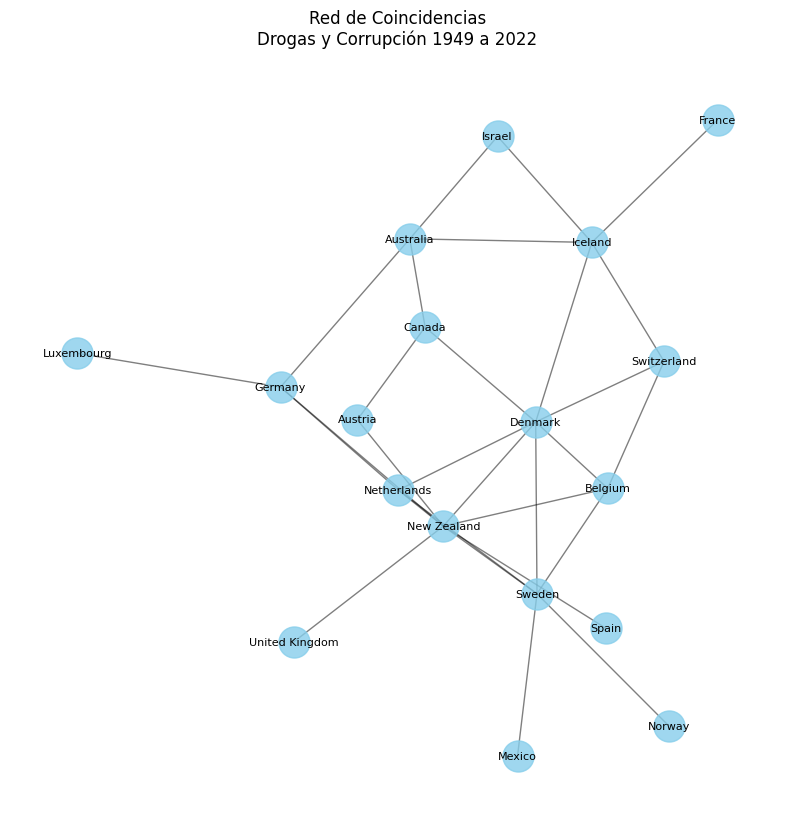

In [20]:
# Llamar a la función con un umbral de coincidencias
grafo_clusters_final(coincidence_matrix, min_coincidencias=10)


### Análisis de Comunidades: Drogas y Corrupción (1949-2022)

#### Variables analizadas:
- **`per605`**: *Law and Order* - Enfoques sobre el orden y la ley, incluyendo fortalecimiento de fuerzas policiales y aplicación de leyes.
- **`per304`**: *Political Corruption* - Referencias a la corrupción en instituciones políticas, su detección y castigo.
- **`per104`**: *Military-Positive* - Perspectiva positiva sobre el rol de las fuerzas armadas, incluyendo defensa y seguridad.
- **`per603`**: *Traditional Morality-Positive* - Promoción de valores tradicionales, frecuentemente relacionados con moralidad y religión.

### Descripción de las Comunidades

#### **Comunidad 0**: [Australia, Austria, Canada, France, Iceland, Israel]
- **Concepto General**: *Democracias avanzadas con políticas de seguridad moderadas y valores tradicionales.*
  - **Características comunes**:
    - Políticas relativamente equilibradas entre valores tradicionales y enfoques progresistas en temas como corrupción.
    - Énfasis en el mantenimiento del orden, pero sin una orientación militar marcada.
  - **Perspectiva según variables**:
    - **Alta relevancia en `per605` (Law and Order)**: Países con fuertes instituciones judiciales y políticas claras en seguridad pública.
    - **Baja relevancia en `per304` (Political Corruption)**: Contextos con menor énfasis en la corrupción, reflejo de sistemas políticos menos afectados por esta problemática.
    - **Moderado interés en `per603` (Traditional Morality)**: Promoción de valores tradicionales, pero no central en los programas presidenciales.

---

#### **Comunidad 1**: [Germany, Luxembourg, Netherlands, New Zealand, Spain, United Kingdom]
- **Concepto General**: *Naciones orientadas al progreso institucional y a la integridad política.*
  - **Características comunes**:
    - Sistemas políticos con políticas públicas sofisticadas, en especial en la lucha contra la corrupción.
    - Menor énfasis en valores tradicionales o militares.
  - **Perspectiva según variables**:
    - **Alta relevancia en `per304` (Political Corruption)**: Esfuerzos claros en la promoción de transparencia e integridad en la administración pública.
    - **Moderado interés en `per605` (Law and Order)**: Instituciones sólidas para el mantenimiento del orden, aunque no central.
    - **Baja relevancia en `per104` (Military-Positive)**: Ausencia de un enfoque militarista en los programas de gobierno.

---

#### **Comunidad 2**: [Belgium, Denmark, Mexico, Norway, Sweden, Switzerland]
- **Concepto General**: *Países con enfoques progresistas y un equilibrio entre seguridad y transparencia.*
  - **Características comunes**:
    - Contextos políticos diversos, desde democracias nórdicas hasta economías emergentes.
    - Énfasis equilibrado entre la promoción de valores tradicionales y el fortalecimiento institucional.
  - **Perspectiva según variables**:
    - **Moderada relevancia en `per605` (Law and Order)**: Seguridad pública como parte de los programas, pero sin un enfoque central.
    - **Alta relevancia en `per603` (Traditional Morality)**: Países que promueven valores tradicionales de manera significativa en sus programas.
    - **Moderado interés en `per304` (Political Corruption)**: Iniciativas claras para abordar la corrupción, aunque no tan central como en Comunidad 1.

---

### Resumen Comparativo de las Comunidades:
| Comunidad   | Concepto General                                                    | Variables predominantes                           |
|-------------|----------------------------------------------------------------------|--------------------------------------------------|
| Comunidad 0 | Democracias avanzadas con políticas moderadas y valores tradicionales. | `per605`: Ley y Orden                            |
| Comunidad 1 | Naciones con orientación progresista e integridad política.          | `per304`: Corrupción Política                    |
| Comunidad 2 | Países equilibrados entre progresismo y valores tradicionales.       | `per603`: Moralidad Tradicional; `per605`: Ley y Orden |

### Conclusión:
Cada comunidad agrupa países con contextos políticos y sociales específicos en torno a los temas seleccionados. Mientras la Comunidad 0 refleja estabilidad institucional y valores moderados, la Comunidad 1 enfatiza transparencia y progreso político. Por su parte, la Comunidad 2 destaca por un balance entre valores tradicionales y esfuerzos en seguridad y transparencia.